# Exploratory Data Analysis

In [1]:
# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master('local') \
    .appName('Project Spotify') \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

In [6]:
import os
data_path = '/home/jovyan'
filename = 'spotify_data.csv'
path_to_data = os.path.join(data_path, filename)

In [7]:
df = spark.read.csv(path_to_data, header=True, inferSchema=True)
df.cache()

DataFrame[track_id: string, album_type: string, release_date: timestamp, is_explicit: boolean, track_popularity: int, danceability: double, energy: double, key: int, loudness: double, mode: int, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, duration_ms: int, time_signature: int, num_follower: int, song_age: double, acoustic: int, afrobeat: int, alternative: int, ambient: int, anime: int, black-metal: int, bluegrass: int, blues: int, british: int, cantopop: int, chicago-house: int, chill: int, classical: int, comedy: int, country: int, dance: int, dancehall: int, death-metal: int, deep-house: int, detroit-techno: int, disco: int, drum-and-bass: int, dub: int, dubstep: int, edm: int, electro: int, electronic: int, emo: int, folk: int, forro: int, french: int, funk: int, garage: int, german: int, gospel: int, groove: int, grunge: int, guitar: int, happy: int, hard-rock: int, hardcore: int, hardstyle: int, hip-hop: in

In [8]:
# Check number of rows
df.count()

578104

In [9]:
# Make sure all rows are distinct
df.distinct().count()

578104

In [10]:
# Check number of columns
len(df.columns)

111

In [11]:
# Separate genre from all other variables
var_to_keep = [
    'track_id',
    'album_type',
    'release_date',
    'is_explicit',
    'track_popularity',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
    'num_follower',
    'song_age'
]

genre = [x for x in df.columns if x not in var_to_keep]

In [12]:
# Count of non-genre variables
len(var_to_keep)

20

In [13]:
# Check genre count
len(genre)

91

## Data Overview

In [14]:
# Check schema of the dataset
df[var_to_keep].printSchema()

root
 |-- track_id: string (nullable = true)
 |-- album_type: string (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- is_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- num_follower: integer (nullable = true)
 |-- song_age: double (nullable = true)



In [15]:
# Chose pandas simply because it has nicer visual than pyspark
data = df[var_to_keep].toPandas()

In [16]:
# Look the first few rows of data
data.head()

,track_id,album_type,release_date,is_explicit,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_follower,song_age
0,1EzrEOXmMH3G43AXT1y7pA,album,2008-05-12,False,85,0.686,0.457,11,-8.322,1,0.0468,0.595,0.0,0.1050,0.718,150.953,242187,4,4174839,3959.0
1,5vjLSffimiIP26QG5WcN2K,single,2017-02-03,False,77,0.608,0.445,2,-9.551,1,0.0550,0.497,0.0,0.0802,0.189,119.886,198853,4,9693,770.0
2,0IktbUcnAGrvD03AWnz3Q8,album,2008-05-12,False,80,0.623,0.417,0,-8.699,1,0.0354,0.296,0.0,0.1350,0.721,130.032,191360,4,4174839,3959.0
3,53QF56cjZA9RTuuMZDrSA6,album,2012-04-13,False,72,0.585,0.303,4,-10.058,1,0.0398,0.694,0.0,0.1150,0.142,136.703,240166,3,4174839,2527.0
4,38YgZVHPWOWsKrsCXz6JyP,album,2007-01-01,False,72,0.672,0.623,9,-5.699,1,0.0297,0.241,0.0,0.0848,0.617,92.018,215173,4,235394,4456.0


In [17]:
# Look at summary statistics of each column
data.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_follower,song_age
count,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,578104.000000,5.781040e+05,578104.000000,5.781040e+05,578104.000000
mean,28.591136,0.547611,0.640254,5.288941,-8.638855,0.631492,0.092613,0.316888,0.212424,0.226613,0.450946,121.796878,2.501241e+05,3.902229,5.828553e+05,2098.613506
std,15.174163,0.176864,0.260147,3.556151,5.441768,0.482401,0.130539,0.341903,0.346059,0.208835,0.263449,29.973841,1.264347e+05,0.427961,2.064100e+06,1818.057366
min,1.000000,0.000000,0.000020,0.000000,-57.002000,0.000000,0.000000,0.000000,0.000000,0.005290,0.000000,0.000000,1.664000e+04,0.000000,0.000000e+00,1.000000
25%,17.000000,0.434000,0.466000,2.000000,-10.391000,0.000000,0.036300,0.011900,0.000000,0.098000,0.229000,98.029000,1.916400e+05,4.000000,1.590700e+04,588.000000
50%,28.000000,0.560000,0.689000,5.000000,-7.191500,1.000000,0.049300,0.161000,0.000345,0.133000,0.432000,121.973000,2.308000e+05,4.000000,6.973800e+04,1571.000000
75%,38.000000,0.679000,0.860000,8.000000,-5.114000,1.000000,0.087100,0.609000,0.359000,0.292000,0.661000,140.038000,2.848000e+05,4.000000,3.101910e+05,3236.000000
max,100.000000,0.992000,1.000000,11.000000,4.140000,1.000000,0.968000,0.996000,1.000000,1.000000,1.000000,248.019000,5.577278e+06,5.000000,4.138313e+07,19265.000000


## Target Variable: Track Popularity

In [18]:
# Inspect statistic summary of target variable
df.select('track_popularity').describe().show()

+-------+-----------------+
|summary| track_popularity|
+-------+-----------------+
|  count|           578104|
|   mean|28.59113585098875|
| stddev|15.17416307858773|
|    min|                1|
|    max|              100|
+-------+-----------------+



In [19]:
# Compute mean
pop_mean = data['track_popularity'].mean()
pop_mean

28.59113585098875

In [20]:
# Compute median
pop_median = data['track_popularity'].median()
pop_median

28.0

In [21]:
# Compute mode
pop_mode = data['track_popularity'].mode()[0]
pop_mode

29

In [22]:
# Split target variable by mean using bucketizer
from pyspark.ml.feature import Bucketizer
splits=[0, pop_mean, 100]
bucketizer = Bucketizer(splits=splits, inputCol='track_popularity', outputCol="split")
with_split = bucketizer.transform(df)

# Inspect the distribution of target variable above and below means
with_split.select('track_popularity','split') \
            .groupBy('split') \
            .count() \
            .withColumn('proportion', col('count') / sum('count').over(Window.partitionBy())) \
            .show()

+-----+------+------------------+
|split| count|        proportion|
+-----+------+------------------+
|  0.0|301832|0.5221067489586648|
|  1.0|276272|0.4778932510413351|
+-----+------+------------------+



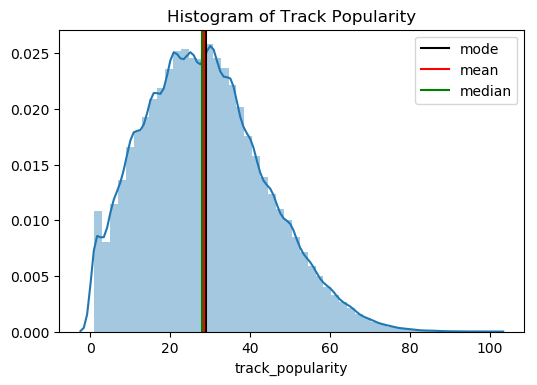

In [23]:
# Plot histogram of track popularity
plt.figure(dpi=100)
sns.distplot(data['track_popularity'])
plt.axvline(pop_mode, color='k', label='mode')
plt.axvline(pop_mean, color='r', label='mean')
plt.axvline(pop_median, color='g', label='median')
plt.title('Histogram of Track Popularity')
plt.legend()
plt.show()

## Feature: Album Type

In [24]:
# Inspect counts of different album type
df.groupBy('album_type').count().show()

+-----------+------+
| album_type| count|
+-----------+------+
|      album|415703|
|compilation| 51577|
|     single|110824|
+-----------+------+



## Feature: Is Explicit

In [25]:
# Inspect count of songs that contain and doesn't contain explicit language
df.groupBy('is_explicit').count().show()

+-----------+------+
|is_explicit| count|
+-----------+------+
|       true| 44495|
|      false|533609|
+-----------+------+



## Feature: Song Duration

In [26]:
# Convert duration from milliseconds to minutes
duration_df = df.withColumn('duration_min', col('duration_ms')/1000/60).select('duration_min')

In [27]:
# Bucketize duration into different length
splits=[-float('inf'), 3, 5, float('inf')]
bucketizer = Bucketizer(splits=splits, inputCol='duration_min', outputCol="split")
with_split = bucketizer.transform(duration_df)

# Inspect the distribution of songs within each bucket
with_split.select('duration_min','split') \
            .groupBy('split') \
            .count() \
            .withColumn('proportion', col('count') / sum('count').over(Window.partitionBy())) \
            .show()

+-----+------+-------------------+
|split| count|         proportion|
+-----+------+-------------------+
|  0.0|109657|0.18968386311113572|
|  1.0|349185| 0.6040176162074644|
|  2.0|119262| 0.2062985206813999|
+-----+------+-------------------+



## Feature: Album Release Year

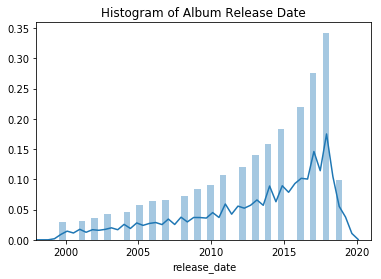

In [28]:
# Plot histogram of album release year
sns.distplot(data['release_date'].apply(lambda date: date.year), bins=120)
plt.title('Histogram of Album Release Date')
plt.xlim(1998,2021)
plt.show()

In [29]:
# Check the count of release year
df.withColumn('release_year', year('release_date')) \
    .groupBy('release_year') \
    .count() \
    .sort('release_year', ascending=False) \
    .show(10)

+------------+-----+
|release_year|count|
+------------+-----+
|        2019|25082|
|        2018|87322|
|        2017|70326|
|        2016|56127|
|        2015|46964|
|        2014|40433|
|        2013|35900|
|        2012|30751|
|        2011|27292|
|        2010|23247|
+------------+-----+
only showing top 10 rows



## Pairplot

In [30]:
# Convert is_explicit into integer type to calculate correlation
df = df.withColumn('is_explicit', col('is_explicit').cast(IntegerType()))

In [31]:
# Extract all the numeric variables
numericFeature = [
    'track_popularity',
    'is_explicit',
    'danceability',
    'energy',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'num_follower',
    'song_age'
]

In [32]:
# Draw a sample of the entire data
sampled_data = df[numericFeature].sample(withReplacement=False, fraction=0.001, seed=316).toPandas()

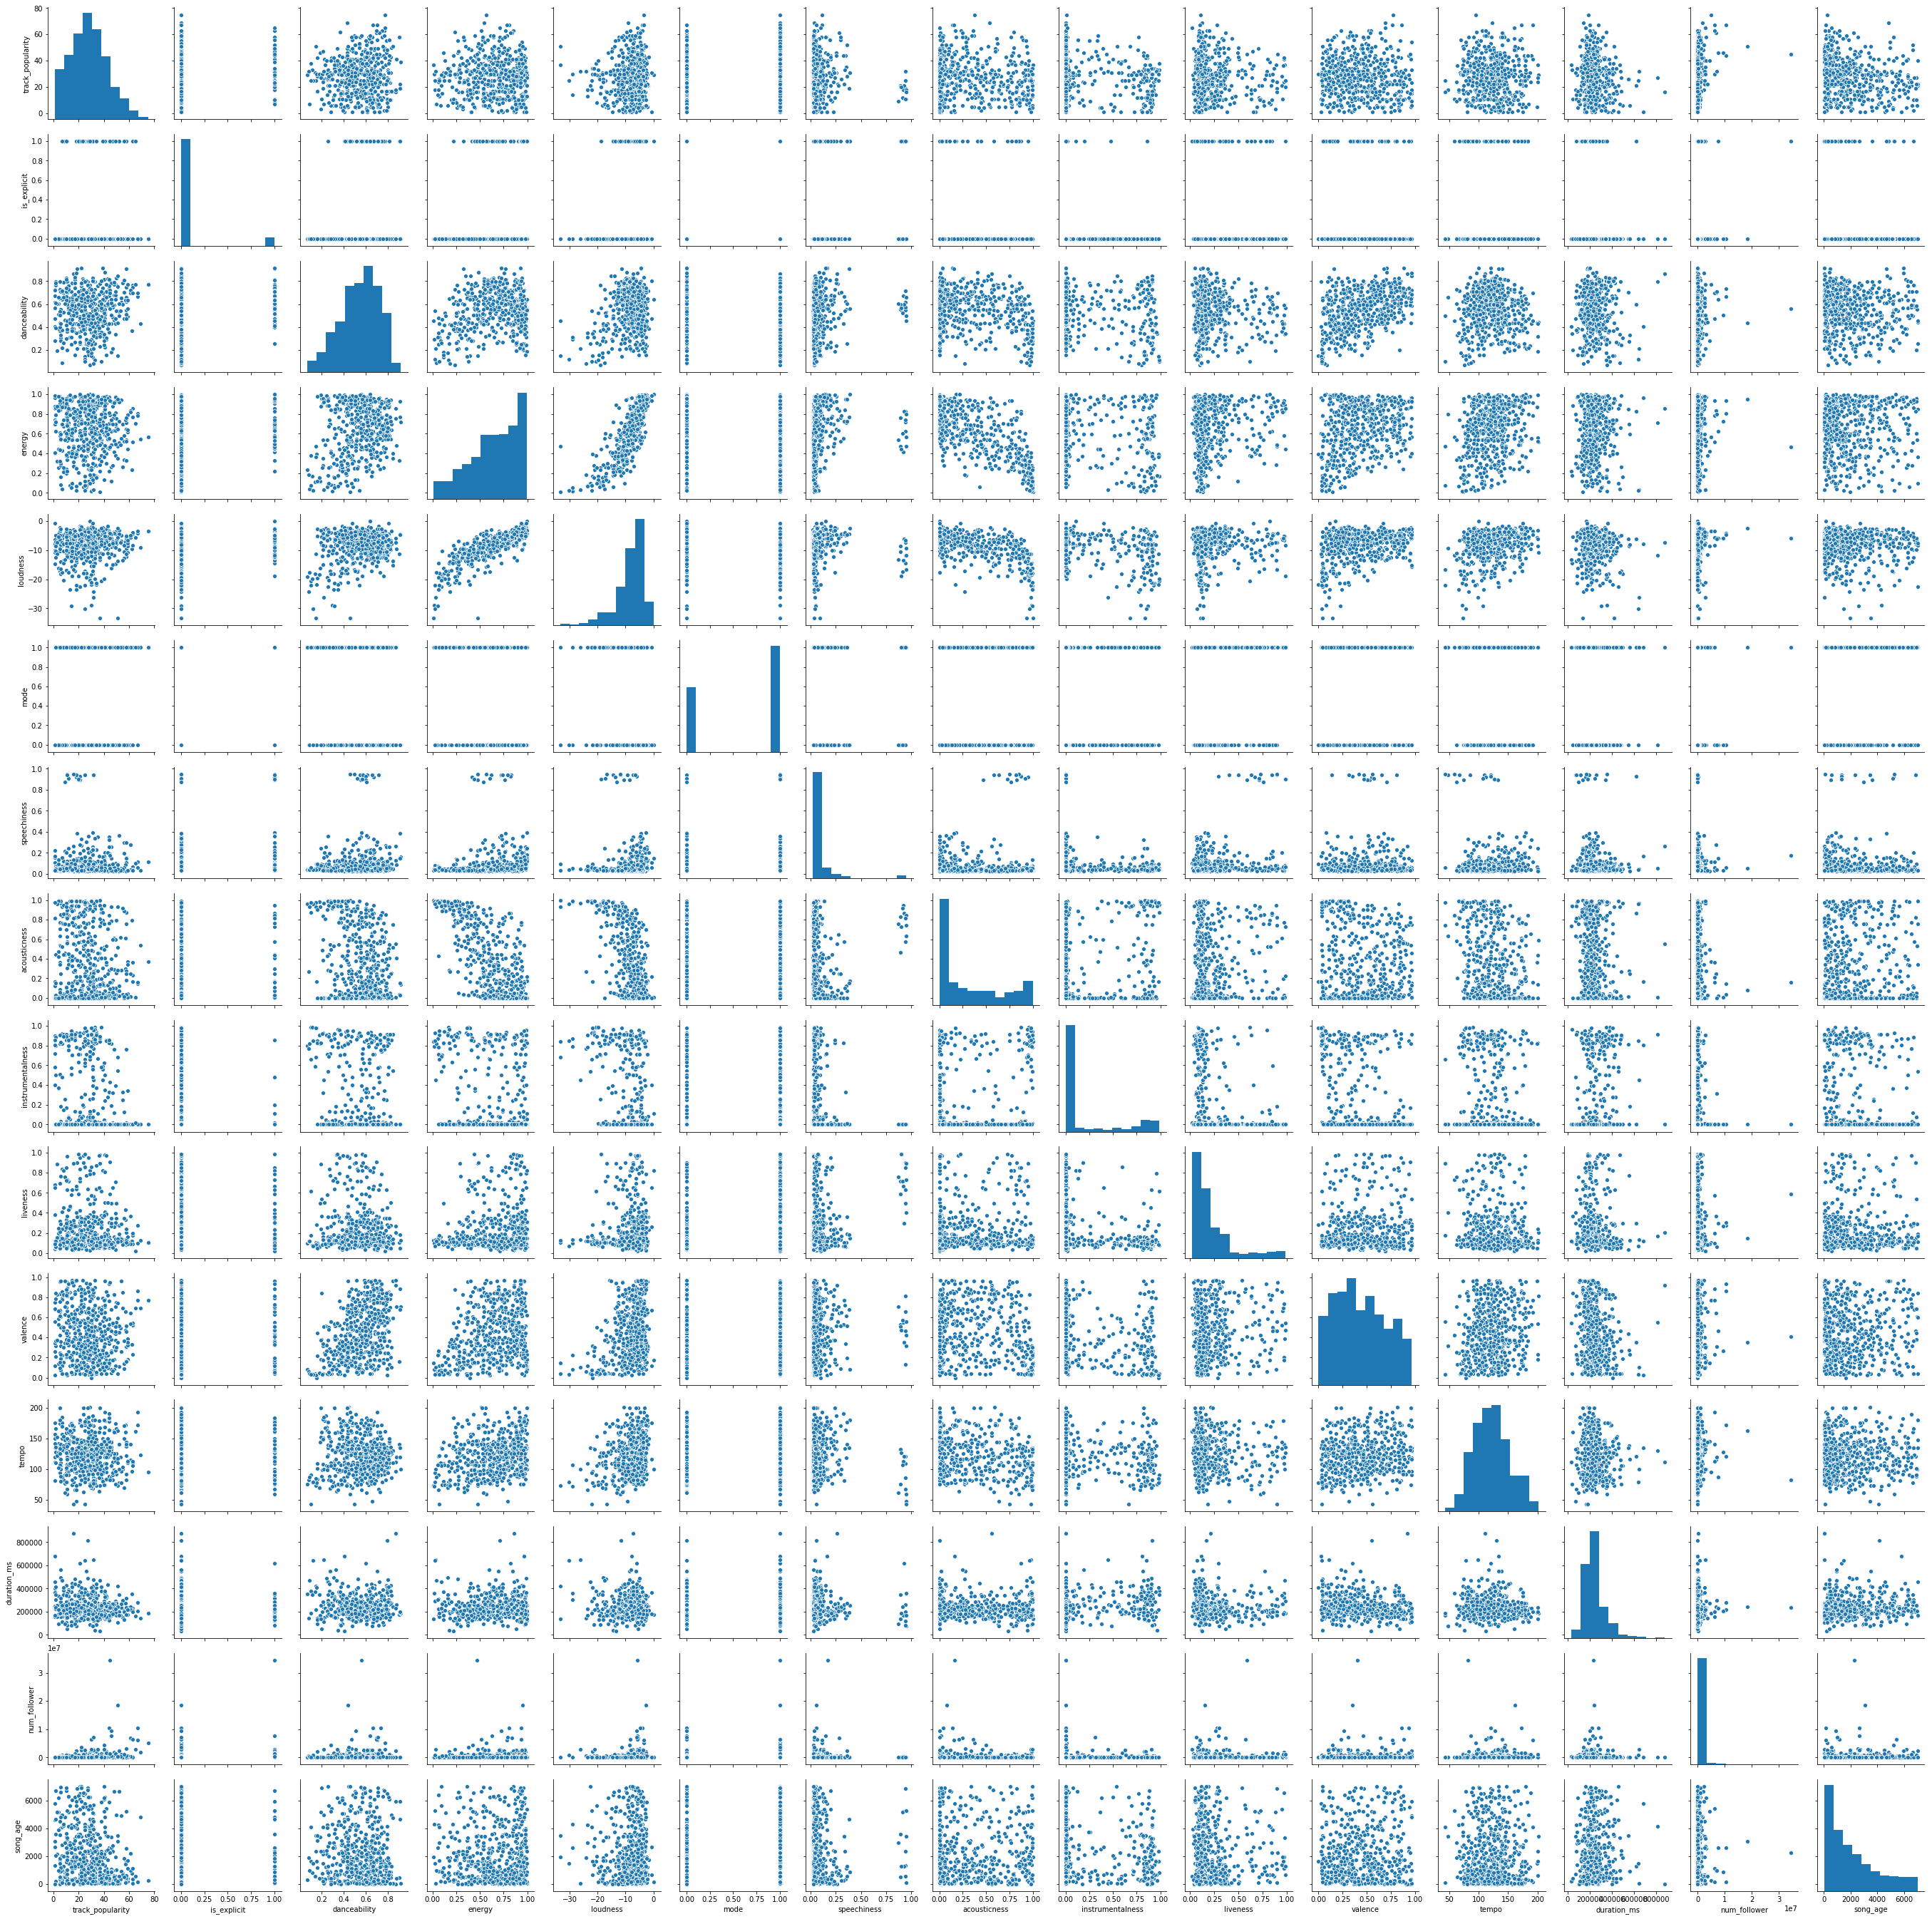

CPU times: user 29.5 s, sys: 20 s, total: 49.5 s
Wall time: 29 s


In [33]:
%%time
# Plot pairplot using the sampled datas
sns.pairplot(sampled_data)
plt.show()

## Correlation Matrix

In [34]:
# Assemble all numeric variables into one feature column
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = numericFeature, outputCol = "features")
corr_df = va.transform(df).select('features', 'track_popularity')

In [35]:
# Compute correlation matrix between all numeric variables
from pyspark.ml.stat import Correlation
corr_matrix = Correlation.corr(corr_df, "features") \
                        .rdd \
                        .flatMap(lambda x: x) \
                        .collect()[0] \
                        .toArray()

In [36]:
# Convert correlation matrix into pandas dataframe
corr = pd.DataFrame(corr_matrix, columns=numericFeature, index=numericFeature)

In [37]:
# Sort the correlation matrix by track popularity
sorted_corr = corr.sort_values(by='track_popularity', ascending=False, axis=1) \
                    .sort_values(by='track_popularity', ascending=False, axis=0)

In [38]:
sorted_corr

,track_popularity,num_follower,is_explicit,loudness,danceability,energy,valence,speechiness,tempo,mode,liveness,duration_ms,acousticness,song_age,instrumentalness
track_popularity,1.000000,0.309337,0.196919,0.159479,0.103929,0.058260,-0.001168,-0.006860,-0.013998,-0.022326,-0.044420,-0.095194,-0.115697,-0.184048,-0.214025
num_follower,0.309337,1.000000,0.137644,0.092291,0.076614,0.048111,0.038331,0.026157,0.005096,-0.009784,0.016756,-0.026869,-0.070525,-0.002499,-0.118541
is_explicit,0.196919,0.137644,1.000000,0.089568,0.124080,0.085698,0.002323,0.387157,-0.018748,-0.028860,0.080961,-0.058186,-0.051454,-0.068564,-0.139477
loudness,0.159479,0.092291,0.089568,1.000000,0.313931,0.774881,0.321921,0.028360,0.243336,-0.026577,0.066707,-0.040845,-0.610796,-0.027617,-0.435077
danceability,0.103929,0.076614,0.124080,0.313931,1.000000,0.199807,0.509170,0.091718,-0.027310,-0.071608,-0.114816,-0.045959,-0.230375,-0.053925,-0.188187
energy,0.058260,0.048111,0.085698,0.774881,0.199807,1.000000,0.293670,0.131792,0.263965,-0.062661,0.189408,0.010788,-0.728858,-0.022059,-0.205120
valence,-0.001168,0.038331,0.002323,0.321921,0.509170,0.293670,1.000000,0.028724,0.067986,0.002393,0.006172,-0.155876,-0.140802,0.085657,-0.307215
speechiness,-0.006860,0.026157,0.387157,0.028360,0.091718,0.131792,0.028724,1.000000,-0.033035,-0.025694,0.297920,-0.048463,0.054551,-0.002704,-0.140282
tempo,-0.013998,0.005096,-0.018748,0.243336,-0.027310,0.263965,0.067986,-0.033035,1.000000,-0.002770,-0.008371,0.009497,-0.242487,-0.014654,-0.037988
mode,-0.022326,-0.009784,-0.028860,-0.026577,-0.071608,-0.062661,0.002393,-0.025694,-0.002770,1.000000,0.028846,-0.034251,0.072573,0.045481,-0.066812


## Heatmap

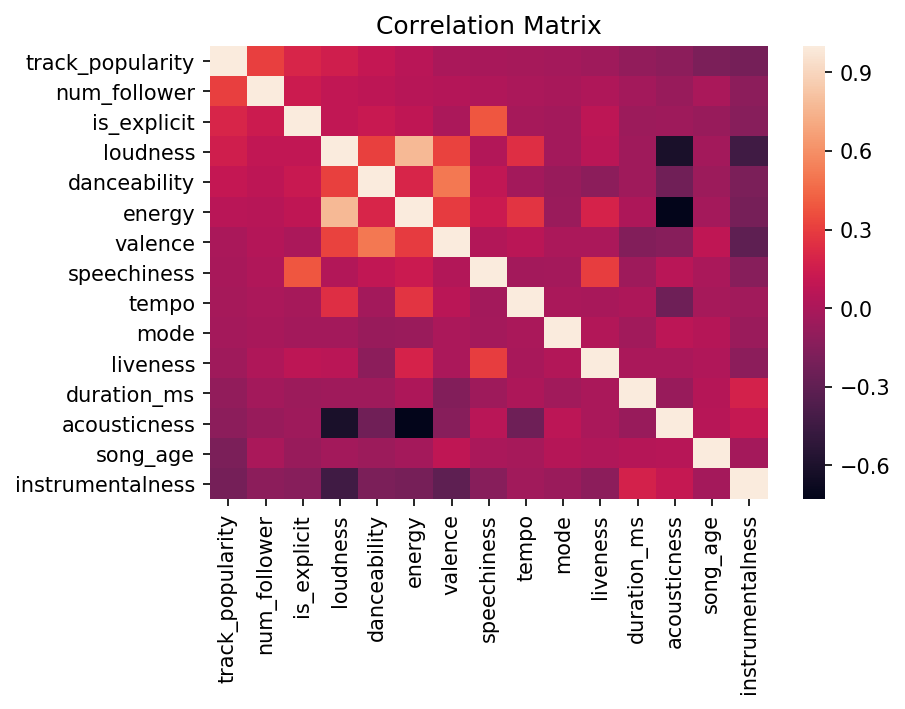

In [39]:
# Plot heatmap of the correlation matrix
plt.figure(dpi=150)
sns.heatmap(sorted_corr)
plt.title('Correlation Matrix')
plt.show()